# Sentiment analysis using different ML and DL algorithms

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import re, numpy as np, pandas as pd

In [3]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\69785hsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


In [5]:
# For ML algorithm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import RidgeClassifier

In [6]:
df=pd.read_csv("sentiment.csv")

In [7]:
df.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


In [8]:
# Keeping only the neccessary columns
df = df[['text','sentiment']]
df.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [9]:
df.shape

(13871, 2)

In [10]:
df.sentiment.value_counts()

Negative    8493
Neutral     3142
Positive    2236
Name: sentiment, dtype: int64

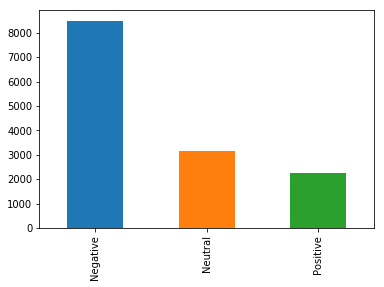

In [11]:
df.sentiment.value_counts().plot(kind='bar')

# Split the dataset

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [13]:
X_train.head()

10428    RT @SalMasekela: These self righteous hypocrit...
13671    RT @brock_a_r: I wonder which candidate is goi...
89       A few of my favorite #Twitter responses to the...
5024     @FoxNews Megyn Kelly's #GOPDebate performance ...
8572     I didn't watch the #GOPDebates tonight, so I w...
Name: text, dtype: object

In [14]:
y_train.head()

10428    Negative
13671    Negative
89        Neutral
5024     Negative
8572     Negative
Name: sentiment, dtype: object

# Text Pre-processing

In [15]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z +_]')
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['rt', 'http']) # extend stopwords; rt means re-tweet
STOPWORDS = set(STOPWORDS)

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
    text = text.strip()
    return text

In [16]:
X_train=[text_prepare(x) for x in X_train]

In [17]:
X_train[:5]

['salmasekela self righteous hypocrites trying god shameless gopdebates',
 'brock_a_r wonder candidate going first accidentally call ben carson help gopdebates',
 'favorite twitter responses gopdebate last night tco 2iqcdrcdlm tco 7tdma3vlm8',
 'foxnews megyn kellys gopdebate performance every bit biased obnoxious candy crowleys 2012 cnn performance',
 'didnt watch gopdebates tonight going ask figured']

In [18]:
X_val=[text_prepare(x) for x in X_val]

In [19]:
X_test=[text_prepare(x) for x in X_test]

### most common words

In [20]:
# Dictionary of all words from train corpus with their counts.
words_counts = {}

from collections import Counter
words_counts = Counter([word for line in X_train for word in line.split(' ')])

# Sorting 
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Top 10
most_common_words[:10]

[('gopdebate', 4811),
 ('gopdebates', 2827),
 ('tco', 1941),
 ('rwsurfergirl', 1072),
 ('trump', 953),
 ('fox', 714),
 ('amp', 578),
 ('debate', 569),
 ('realdonaldtrump', 560),
 ('news', 504)]

# Word Embedding with TF-IDF

- Use class TfidfVectorizer from scikit-learn
- Filter out too rare words (occur less than in 5 titles)
- Filter out too frequent words (occur more than in 90% of the tweets).
- Use 2-gram along with 1-gram

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test - input text       
        return TF-IDF vectorizer for each dataset
    """
    
    # filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the tweets)
    # ngram!!! -->  ngram_range=(1,2)
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5, token_pattern='(\S+)')
    
    # Fit and transform the vectorizer on the train set
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    
    # Transform the test and val sets 
    X_val_tfidf = tfidf_vectorizer.transform(X_val)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    return X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_
    
    
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)

In [22]:
X_train_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.40615562],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# Modeling

### a)-Logistic regression

In [23]:
logreg = LogisticRegression()

logreg.fit(X_train_tfidf, y_train)

# Return accuracy
scores = cross_val_score(logreg, X_train_tfidf, y_train, scoring='accuracy', n_jobs=-1, cv=3)

print('Cross-validation mean accuracy {0:.2f}%, std {1:.2f}.'.format(np.mean(scores) * 100, np.std(scores) * 100))

Cross-validation mean accuracy 67.86%, std 0.38.


In [24]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### b)-LinearSVC

In [25]:
svc = LinearSVC(dual=False)
svc.fit(X_train_tfidf, y_train)


scores = cross_val_score(svc, X_test_tfidf, y_test, scoring='accuracy', n_jobs=-1, cv=3)
print('Cross-validation mean accuracy {0:.2f}%, std {1:.2f}.'.format(np.mean(scores) * 100, np.std(scores) * 100))

Cross-validation mean accuracy 63.76%, std 0.45.


### c)-OneVsRest

In [26]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training text and sentiment
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.
    
    model = OneVsRestClassifier(LogisticRegression(penalty='l2', C=1.0))
    model.fit(X_train, y_train)
    return model
    
 
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def evaluation_scores(y_val, predicted):
    
    print ("Accracy={}".format(accuracy_score(y_val, predicted)))
    print ("F1_macro={}".format(f1_score(y_val, predicted, average='macro')))
    print ("F1_micro={}".format(f1_score(y_val, predicted, average='micro')))
    print ("F1_wted={}".format(f1_score(y_val, predicted, average='weighted')))
    
print('Tfidf')
evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Tfidf
Accracy=0.6906939214631522
F1_macro=0.5550930129562491
F1_micro=0.6906939214631522
F1_wted=0.6518652578108339


In [28]:
print('TFIDF')
evaluation_scores(y_val,y_val_predicted_labels_tfidf)

TFIDF
Accracy=0.6906939214631522
F1_macro=0.5550930129562491
F1_micro=0.6906939214631522
F1_wted=0.6518652578108339


### d)-LSTM with Keras

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

In [30]:
X=[text_prepare(x) for x in df['text']]

In [31]:
X[:5]

['nancyleegrahn everyone feel climate change question last night exactly gopdebate',
 'scottwalker didnt catch full gopdebate last night scotts best lines 90 seconds walker16 tco zsff',
 'tjmshow mention tamir rice gopdebate held cleveland wow',
 'robgeorge carly fiorina trending hours debate men justcompleted gopdebate says shes',
 'danscavino gopdebate w realdonaldtrump delivered highest ratings history presidential debates trump2016 tco']

In [32]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X)

In [33]:
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  248,  348,  340,  281,   46,   11,   18,
         910,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         251,   57, 1818,  485,    1,   11,   18,   97, 1290, 1433, 1217,
         723,    3],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  386,    1, 1666,
         580,  419],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,  202,  156,  616,    8,  102,    1,
         129,  668],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0, 1066,    1,  132,    7, 1999, 1553,  150,  541,   98,  106,
         294,    3]])

### Create LSTM model

In [34]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 24, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 24, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 591       
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


**Encoding the prediction column “sentiment” (Positive, Neutral, Negative)**

In [35]:
Y=pd.get_dummies(df['sentiment']).values

In [36]:
Y[:5]

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [78]:
[print(df['sentiment'][i], Y[i]) for i in range(0,5)]

Neutral [0 1 0]
Positive [0 0 1]
Neutral [0 1 0]
Positive [0 0 1]
Positive [0 0 1]


[None, None, None, None, None]

**Train the LSTM model for 20 epochs**

In [37]:
# create train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print("Trianing ", X_train.shape,Y_train.shape)
print("Testing ",X_test.shape,Y_test.shape)



Trianing  (9293, 24) (9293, 3)
Testing  (4578, 24) (4578, 3)


In [38]:
batch_size = 32
epochs = 20

In [39]:
from keras.callbacks import EarlyStopping

In [40]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Instructions for updating:
Use tf.cast instead.
Train on 8363 samples, validate on 930 samples
Epoch 1/20
8363/8363 [==============================] - 7s 813us/step - loss: 0.8441 - acc: 0.6424 - val_loss: 0.7748 - val_acc: 0.6957
Epoch 2/20
8363/8363 [==============================] - 6s 685us/step - loss: 0.6931 - acc: 0.7013 - val_loss: 0.7775 - val_acc: 0.6903
Epoch 3/20
8363/8363 [==============================] - 6s 690us/step - loss: 0.6324 - acc: 0.7300 - val_loss: 0.7664 - val_acc: 0.6677
Epoch 4/20
8363/8363 [==============================] - 6s 697us/step - loss: 0.5915 - acc: 0.7509 - val_loss: 0.7992 - val_acc: 0.6602
Epoch 5/20
8363/8363 [==============================] - 6s 766us/step - loss: 0.5556 - acc: 0.7654 - val_loss: 0.8375 - val_acc: 0.6710
Epoch 6/20
8363/8363 [==============================] - 8s 900us/step - loss: 0.5330 - acc: 0.7772 - val_loss: 0.8741 - val_acc: 0.6667


In [41]:
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))

Training Accuracy: 0.8006
Training Loss: 0.4910


In [42]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing Loss:  {:.4f}".format(loss))

Testing Accuracy:  0.6538
Testing Loss:  0.8638


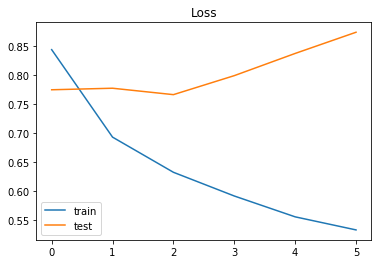

In [43]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

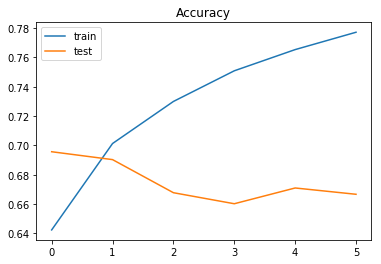

In [44]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [45]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

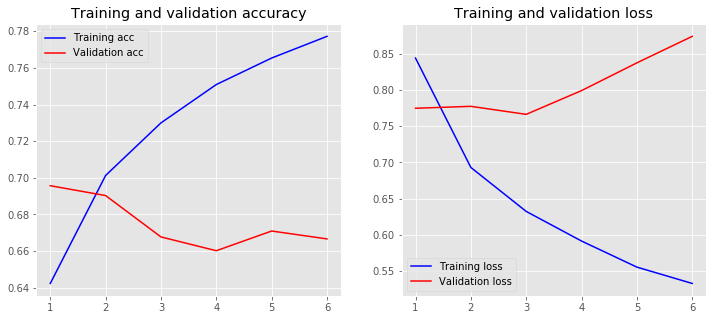

In [46]:
 plot_history(history)

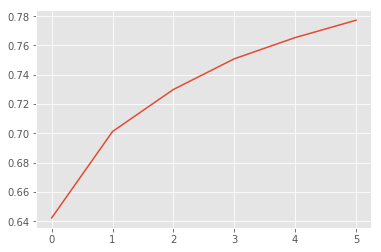

In [47]:
# plot metrics for training accuracy
from matplotlib import pyplot
pyplot.plot(history.history['acc'], label='train')
pyplot.show()

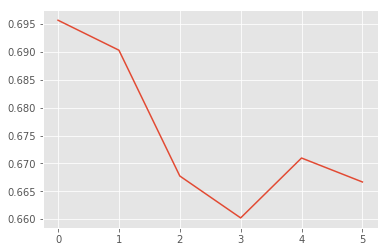

In [48]:
# plot metrics for test accuracy
from matplotlib import pyplot
pyplot.plot(history.history['val_acc'], label='test')
pyplot.show()

### F1, precision,recall

https://pypi.org/project/keras-metrics/
https://stackoverflow.com/questions/43076609/how-to-calculate-precision-and-recall-in-keras

In [51]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()


In [56]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)

In [53]:
text_labels = encoder.classes_
 
for i in range(10):
    prediction = model.predict(np.array([X_test[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    print(test_files_names.iloc[i])
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label)

AttributeError: 'LabelBinarizer' object has no attribute 'classes_'

In [58]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_test, yhat_probs)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [ ]:
import keras
import keras_metrics as km
embed_dim = 128
lstm_out = 196

model2 = Sequential()
model2.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model2.add(SpatialDropout1D(0.4))
model2.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(3,activation='softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = [km.binary_precision(), km.binary_recall()])
print(model2.summary())

In [ ]:
Y=pd.get_dummies(df['sentiment']).values

In [ ]:
# create train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print("Trianing ", X_train.shape,Y_train.shape)
print("Testing ",X_test.shape,Y_test.shape)

In [ ]:
batch_size = 32
epochs = 20

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
history = model2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


In [ ]:
loss = model.evaluate(X_train, Y_train, verbose=False)

In [ ]:
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training Loss: {:.4f}".format(loss))

In [ ]:
import keras as keras
import numpy as np
from keras.optimizers import SGD
from sklearn.metrics import precision_score, recall_score

model = keras.models.Sequential()
# ...
sgd = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(model.predict(X_val))

        y_val = np.argmax(y_val, axis=1)
        y_predict = np.argmax(y_predict, axis=1)

        self._data.append({
            'val_recall': recall_score(y_val, y_predict),
            'val_precision': precision_score(y_val, y_predict),
        })
        return

    def get_data(self):
        return self._data


metrics = Metrics()
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[metrics])
metrics.get_data()

In [ ]:

model2 = Sequential()
model2.add(keras.layers.Dense(1, activation="sigmoid", input_dim=2))
model2.add(keras.layers.Dense(1, activation="softmax"))

model2.compile(optimizer="sgd",
              loss="binary_crossentropy",
              metrics=[keras_metrics.precision(), keras_metrics.recall()])

In [ ]:
print(model2.summary())

In [ ]:
history = model2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

In [ ]:
"""

import keras
import keras_metrics

model = models.Sequential()
model.add(keras.layers.Dense(1, activation="sigmoid", input_dim=2))
model.add(keras.layers.Dense(1, activation="softmax"))

model.compile(optimizer="sgd",
              loss="binary_crossentropy",
              metrics=[keras_metrics.precision(), keras_metrics.recall()])

"""

In [ ]:
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
    
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
        val_targ = self.model.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print '— val_f1: %f — val_precision: %f — val_recall %f' %(_val_f1, _val_precision, _val_recall)
        return
    
    metrics = Metrics()

In [ ]:
#print (metrics.val_f1s)

In [ ]:
print("Training Loss: {:.4f}".format(loss))

In [ ]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=callbacks=[metrics])


### Alternative way of matrics calculation

In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)

In [ ]:
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)

In [ ]:
yhat_probs.shape

In [ ]:
yhat_classes.shape

In [ ]:
# reduce to 1d array
yhat_probs = yhat_probs[: , 0]
yhat_classes = yhat_classes[: , 0]

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)

### 3rd try

In [ ]:
import keras as keras

In [ ]:
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(model.predict(X_val))

        y_val = np.argmax(y_val, axis=1)
        y_predict = np.argmax(y_predict, axis=1)

        self._data.append({
            'val_recall': recall_score(y_val, y_predict),
            'val_precision': precision_score(y_val, y_predict),
        })
        return

    def get_data(self):
        return self._data

In [ ]:
metrics = Metrics()

In [ ]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[metrics])

In [ ]:
metrics.get_data()

### 4th

In [ ]:
from sklearn.metrics import classification_report

history = model.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, Y_test), shuffle=True)

In [ ]:
pred = model.predict(X_test, batch_size=32, verbose=1)

In [ ]:
pred.shape

In [ ]:
pred[:5]

In [ ]:
predicted = np.argmax(pred, axis=1)

In [ ]:
predicted.shape

In [ ]:
predicted[:5]

In [ ]:
Y_test.shape

In [ ]:
y_test_hat=np.argmax(Y_test, axis=1)

In [ ]:
report = classification_report(np.argmax(y_test, axis=1), predicted)
print(report)

In [ ]:
pred[:5]

In [ ]:
Y_test[:5]

In [ ]:
X_train, X_test, Y_train, Y_test

# Recall and F-score
The one that worked

In [59]:
import keras
import keras_metrics as km
embed_dim = 128
lstm_out = 196

model2 = Sequential()
model2.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model2.add(SpatialDropout1D(0.4))
model2.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(3,activation='softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = [km.binary_precision(), km.binary_recall()])
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 24, 128)           256000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 24, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 591       
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
Y=pd.get_dummies(df['sentiment']).values

In [61]:
# create train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print("Trianing ", X_train.shape,Y_train.shape)
print("Testing ",X_test.shape,Y_test.shape)

Trianing  (9293, 24) (9293, 3)
Testing  (4578, 24) (4578, 3)


In [62]:
batch_size = 32
epochs = 20

In [63]:
from keras.callbacks import EarlyStopping

In [64]:
history = model2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 8363 samples, validate on 930 samples
Epoch 1/20
8363/8363 [==============================] - 7s 824us/step - loss: 0.8454 - precision: 0.6912 - recall: 0.8263 - val_loss: 0.7723 - val_precision: 0.7174 - val_recall: 0.8726
Epoch 2/20
8363/8363 [==============================] - 6s 750us/step - loss: 0.6977 - precision: 0.7773 - recall: 0.8311 - val_loss: 0.7528 - val_precision: 0.7504 - val_recall: 0.7766
Epoch 3/20
8363/8363 [==============================] - 6s 773us/step - loss: 0.6295 - precision: 0.8082 - recall: 0.8335 - val_loss: 0.7575 - val_precision: 0.7432 - val_recall: 0.8133
Epoch 4/20
8363/8363 [==============================] - 7s 798us/step - loss: 0.5858 - precision: 0.8261 - recall: 0.8507 - val_loss: 0.7925 - val_precision: 0.7586 - val_recall: 0.7679
Epoch 5/20
8363/8363 [==============================] - 6s 748us/step - loss: 0.5525 - precision: 0.8398 - recall: 0.8542 - val_loss: 0.8473 - val_precision: 0.7368 - val_recall: 0.8499


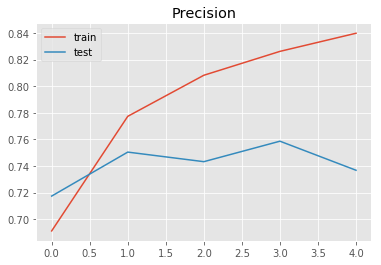

In [65]:
plt.title('Precision')
plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='test')
plt.legend()
plt.show();

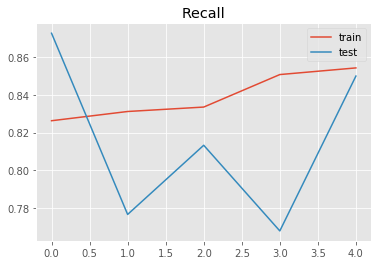

In [66]:
plt.title('Recall')
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='test')
plt.legend()
plt.show();

# working for condusion matrix

In [69]:
predictions = model.predict(X_test)

In [72]:
df['text'][0]

'RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate'

In [70]:
Y_test[0]

array([0, 0, 1], dtype=uint8)

In [71]:
y_test[0]

'Neutral'

In [73]:
predictions[0]

array([0.5253584 , 0.09201041, 0.3826312 ], dtype=float32)

In [74]:
[print(df['text'][i], predictions[i], Y_test[i]) for i in range(0, 5)]

RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate [0.5253584  0.09201041 0.3826312 ] [0 0 1]
RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF… [0.31930026 0.32030672 0.360393  ] [0 0 1]
RT @TJMShow: No mention of Tamir Rice and the #GOPDebate was held in Cleveland? Wow. [0.1783911  0.12872013 0.69288874] [0 0 1]
RT @RobGeorge: That Carly Fiorina is trending -- hours after HER debate -- above any of the men in just-completed #GOPdebate says she's on … [0.07785433 0.05288474 0.86926097] [0 0 1]
RT @DanScavino: #GOPDebate w/ @realDonaldTrump delivered the highest ratings in the history of presidential debates. #Trump2016 http://t.co… [0.23244917 0.28532833 0.4822224 ] [0 1 0]


[None, None, None, None, None]

In [76]:
pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==2:
        pos_count += 1
    elif np.argmax(prediction)==1:
        neu_count += 1
    else:
        neg_count += 1
    
    if np.argmax(Y_test[i])==2:
        real_pos += 1
    elif np.argmax(Y_test[i])==1:    
        real_neu += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg)

Positive predictions: 732
Neutral predictions: 732
Negative predictions: 3114
Real positive: 739
Real neutral: 1030
Real negative: 2809


In [80]:
from sklearn.metrics import classification_report

In [88]:
predictions[0]

array([0.5253584 , 0.09201041, 0.3826312 ], dtype=float32)

In [82]:
Y_test[0]

array([0, 0, 1], dtype=uint8)

In [86]:
report = classification_report(Y_test, predictions)
print(report)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [89]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, predictions)
cm

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

**As we have a 3 column array. We need 1-column array having 0,1,2 dummy value**